# ResNet50 Classifier

To provide a comparable model for the HOG/SVM classfier, we use a common Convolutional Neural Network (CNN) architecture: **ResNet50**.

ResNet models are built using **Residual Blocks**, which help deep networks to avoid degradation in training error [1].

> [1] K. He, X. Zhang, S. Ren, and J. Sun, “Deep residual learning for image recognition,” Proc. IEEE Comput. Soc. Conf. Comput. Vis. Pattern Recognit., vol. 2016-December, pp. 770–778, 2016.

![Pull quote from original ResNet paper](img/00-resnet-text.png) 

In [1]:
# load images with tf.data.Dataset
# see here: https://www.tensorflow.org/tutorials/load_data/images
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pathlib

SCALE_DOWN_FACTOR = 4
df_sizes = pd.read_csv("data/data/data/sorted_metadata.csv")
path="data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
BATCH_SIZE = 16
IMG_HEIGHT = int(df_sizes.n_rows.mean()/SCALE_DOWN_FACTOR)
IMG_WIDTH = int(df_sizes.n_cols.mean()/SCALE_DOWN_FACTOR)
CLASS_NAMES = np.array(["Normal", "Pnemonia"])
print("--- Training on images of size ({},{}) ---".format(IMG_WIDTH,IMG_HEIGHT))

2.0.0
--- Training on images of size (332,243) ---


In [2]:
# train_path = f"{path}/train_modified" # train on all images
train_path = f"{path}/train_unique" # train on images from unique patients
data_dir = pathlib.Path(train_path)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [3]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def get_onehot(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    onehot = tf.reshape(tf.one_hot(tf.where(CLASS_NAMES==parts[-2]),2), (2,))
    print(onehot.shape)
    return onehot

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    # label = get_label(file_path)
    label = get_onehot(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [4]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(2,)


In [5]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=500):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Repeat forever
        ds = ds.repeat()

        ds = ds.batch(BATCH_SIZE)

        # `prefetch` lets the dataset fetch batches in the background while the model
        # is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

In [6]:
filename = 'data/train_cache'
train_ds = prepare_for_training(labeled_ds,cache=filename)

# image_batch, label_batch = next(iter(train_ds))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,5,n+1)
        im = image_batch[n]
        n_row, n_col, _ = im.shape
        im = np.reshape(im, (n_row, n_col))
        plt.imshow(im, cmap='gray')
        plt.title(CLASS_NAMES[tf.where(label_batch[n]==1)][0].title())
        plt.axis('off')

/home/mason_delro_gmail_com/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


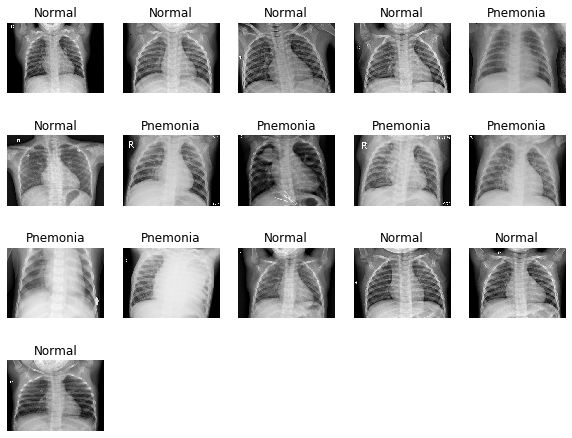

In [8]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Loading, Fitting ResNet50



In [7]:
data_format = "channels_last"
inp_shape = (IMG_HEIGHT,IMG_WIDTH,1) # channels_last
input_tensor = None
resnet = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=input_tensor, input_shape=inp_shape,
    pooling=None, classes=2
)

df_sizes = pd.read_csv("data/data/unique_sorted_metadata.csv")
path="data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
num_examples = df_sizes[df_sizes.dataset_type == "TRAIN"].shape[0]
full_batches = num_examples // BATCH_SIZE

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs=50
model_path = "model/resnet50"
model_json = resnet.to_json()
model_out_base = "{}/model_H{}_W{}_unique_{:03d}epoch".format(model_path,IMG_HEIGHT,IMG_WIDTH,epochs)
weights_file = "{}.h5".format(model_out_base)

checkpoint = ModelCheckpoint(
    filepath=weights_file,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

In [9]:
resnet.compile(optimizer='adam',
               loss=tf.keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy']
              ) 
resnet.summary()
resnet.fit(train_ds,
           epochs=epochs,
           steps_per_epoch=full_batches,
           callbacks=[checkpoint],
           verbose=1)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 243, 332, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 249, 338, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 166, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 166, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
# save model+weights for testing later

# model_path = "model/resnet50"
# model_json = resnet.to_json()
# model_out_base = "{}/model_H{}_W{}".format(model_path,IMG_HEIGHT,IMG_WIDTH)
# with open("{}.json".format(model_out_base), "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# resnet.save("{}.h5".format(model_out_base))

In [17]:
# test model on training set for now
# TO-DO: Functionalize pipeline to get tf.Data obj for test set
resnet.evaluate(train_ds,steps=full_batches)

165/165 [==============================] - 915s 6s/step - loss: 3.9446 - accuracy: 0.7466


[3.944648027420044, 0.7465909123420715]